### **Masked Pre-trained Model Enables Universal Zero-shot Denoiser**


This repository provides a demonstration of how to use our proposed MPI paradigm for zero-shot denoising with a single noisy image.

# Set Device

In [1]:
#Enter device here, 'cuda' for GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'
device = 'cuda'

# Import Libs

In [2]:
import time
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

from util import add_noise_torch,read_img,smooth_out_withmask,\
    compare_psnr,get_args,get_model,test,tensor2plot

# Load Image & Add Noise

In [3]:

impath='./denoise/kate.png'

clean_img = read_img(impath)
print(clean_img.shape) #C H W

torch.Size([3, 512, 512])


Add noise to the image

In [4]:
noise_type = 'gauss' # Either 'gauss' or 'poiss'
noise_level = 25

noisy_img = add_noise_torch(clean_img, noise_level, noise_type)

clean_img = clean_img.to(device)
noisy_img = noisy_img.to(device)

Display image

PSNR=20.93;	SSIM=0.271


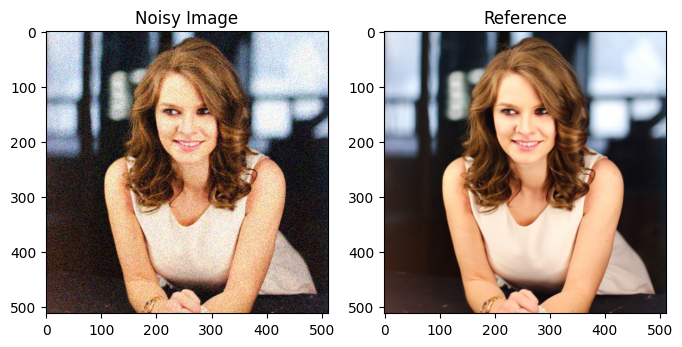

In [5]:
noisy_plot = tensor2plot(noisy_img)
clean_plot = tensor2plot(clean_img)
psnr_noisy,ssim_noisy=test(noisy_img,clean_img)
print('PSNR=%.2f;\tSSIM=%.3f'%(psnr_noisy,ssim_noisy))

fig, ax = plt.subplots(1, 2,figsize=(8,8))

ax[0].imshow(noisy_plot)
ax[0].set_title('Noisy Image')

ax[1].imshow(clean_plot)
ax[1].set_title('Reference')

data={'img_noisy_torch':noisy_img,
    'img_gt_torch':clean_img}

# Set Network & Load Parameters

Define network architecture $\mathcal{D}(\cdot)$ and load parameter $\theta$

In [6]:
arg_path='./configs/Fill_m_syn.yml' # './configs/Fill_s_syn.yml' for faster version
args=get_args(arg_path)

resume=True # 'False' for baseline
net_fill,lr_groups=get_model(args,resume=resume, device=device)

optimizer_fill = optim.Adam(lr_groups, lr=args.LR)
criterion_fill = torch.nn.MSELoss().to(device)

Number of params: 747395


# Optimize

The iterative optimizing process can be described as follows:

<b>for</b> $t$ from $1$ to $T$ do

&nbsp;&nbsp;&nbsp;&nbsp;generate random mask $M_t$ with mask ratio $p$

$~~~~y_t=\mathcal{D}_{\theta}(M_t\odot x)$

$~~~~\hat{M_t}=\neg M_t$

$~~~~\theta \leftarrow \theta-\nabla_\theta \left\|\hat{M_t}\odot y_t-\hat{M_t}\odot x\right\|_2$

$~~~~\overline{y} \leftarrow \hat{M_t} \odot (\beta\cdot \overline{y}+(1-\beta)\cdot y_t)+M_t\odot \overline{y}$

<b>end<b>


In [7]:
def train(args,data,net_fill,optimizer_fill,criterion_fill):
    psnr_list=[];psnr_noisy_list=[]
    img_noisy_torch=data['img_noisy_torch'].to(device)
    img_gt_torch=data['img_gt_torch'].to(device)
    out_avg=img_noisy_torch.clone().detach() if args.load_initial=='noisy' else None
    img_noisy_torch=img_noisy_torch.unsqueeze(0)

    start = time.time()
    for iter in range(args.NUM_ITER):
        # for random mask
        out = net_fill(img_noisy_torch)
        mask = net_fill.get_mask()

        if args.IS_SMOOTH:
            out_avg=smooth_out_withmask(out_avg,out,mask,exp_weight=args.EXP_WEIGHT)

        optimizer_fill.zero_grad()
        loss_fill = criterion_fill(torch.mul(out,1-mask), torch.mul(img_noisy_torch,1-mask))
        loss_fill.backward()
        optimizer_fill.step()

        if (iter+1) % args.show_every ==0:
            psnr_noisy = compare_psnr(img_noisy_torch.detach(), out_avg.detach()) if not out_avg==None else 0
            psnr_gt    = compare_psnr(torch.mul(img_gt_torch.detach(),1-mask), torch.mul(out[0].detach(),1-mask))
            psnr_gt_sm = compare_psnr(img_gt_torch.detach(), out_avg.detach()) if not out_avg==None else 0
            
            print ('Iteration:%05d  PSNR_noisy: %f PSRN_gt: %f PSNR_gt_sm: %f' \
                % (iter, psnr_noisy, psnr_gt, psnr_gt_sm), '\r', end='')
            psnr_list.append(psnr_gt_sm)
            psnr_noisy_list.append(psnr_noisy)

    end = time.time();ref_time=end-start
    psnr,ssim=test(img_gt_torch.detach(),out_avg[0].detach())
    return psnr,ssim,out_avg[0].detach()

Start denoising

In [8]:
start=time.time()
psnr_out,ssim_out,out_avg=train(args,data,net_fill,optimizer_fill,criterion_fill)
end=time.time();ref_time=end-start

PSNR,SSIM & Inference time

In [9]:
print('PSNR=%.2f;\tSSIM=%.3f'%(psnr_out,ssim_out))
print('Total time: %.1f s'%ref_time)

PSNR=34.72;	SSIM=0.926
Total time: 53.8 s


Display clean, noisy, and denoised images.

Text(0.5, 1.0, 'Denoised Image')

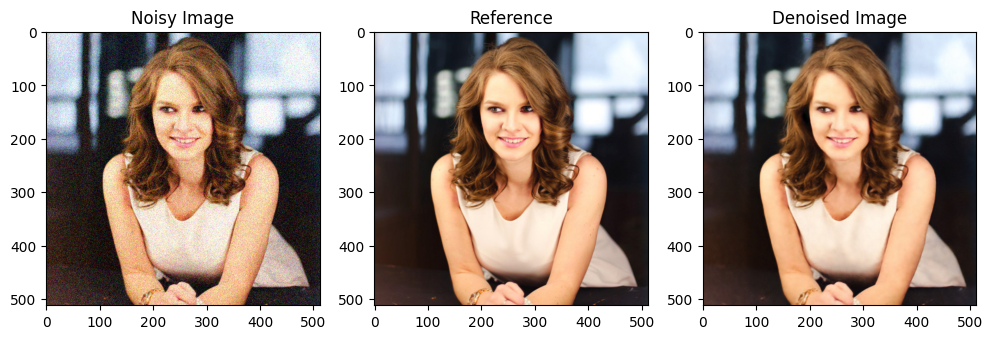

In [10]:
out_avg_plt = tensor2plot(out_avg)

fig, ax = plt.subplots(1, 3,figsize=(12,12))

ax[0].imshow(noisy_plot)
ax[0].set_title('Noisy Image')

ax[1].imshow(clean_plot)
ax[1].set_title('Reference')


ax[2].imshow(out_avg_plt)
ax[2].set_title('Denoised Image')